# Nova secção

~~~~~~~~~~~~~~~~GENOMAS~~~~~~~~~~~~~~~~
GENOMA Mycoplasma genitalium
gene[451][469] BOX -35:  0.462732338428289 BOX -10:  0.44913085443769923 Score: 0.20782737053425204 
 AATCAATTGAACTGATTATTTTCAGCAGTAATAATTACATATG
 ........TTGACA................TATAAT....ATG 
 Number of residues: 6.0 

gene[546][615] BOX -35:  0.36240387717139705 BOX -10:  0.6795734954758144 Score: 0.24628006958335397 
 TATTTTAGAGAGTATTAATTATTACTATAATTAAGCATTTATG
 TTGACA....................TATAAT........ATG 
 Number of residues: 23.0 

gene[2461][2527] BOX -35:  0.4036428558704762 BOX -10:  0.4872154406584398 Score: 0.19666103189156517 
 GATGTTGTTAACCTACCTTTAAAAATTAAAGTTATTAATAATG
 ..TTGACA...................TATAAT.......ATG 
 Number of residues: 22.0 

gene[4285][4303] BOX -35:  0.5374338681190765 BOX -10:  0.29106094153131895 Score: 0.1564260076655571 
 TTAAACGTTGAAAAATCTAACTTTGAACAAATCTTTAATAATG
 ........TTGACA................TATAAT....ATG 
 Number of residues: 6.0 

gene[5015][7319] BOX -35:  0.2707581436576306 BO

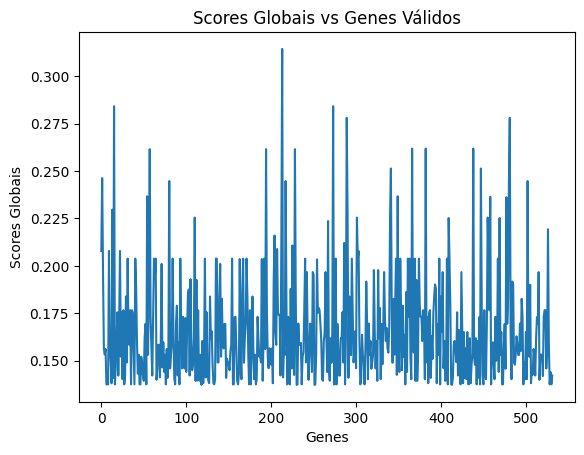

Tamanho médio da proteína: 30.353383458646615
Desvio padrão médio do tamanho das proteínas: 67.70240558233448


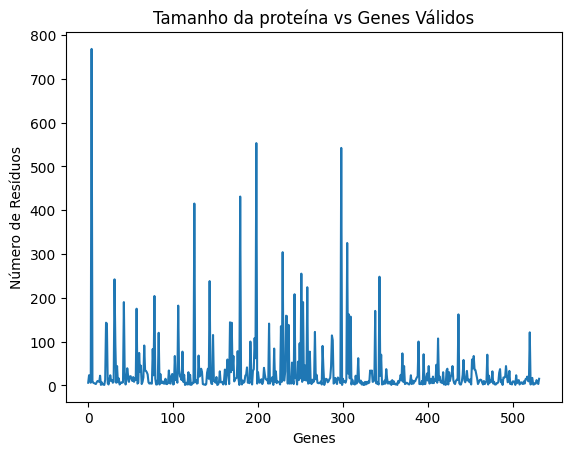

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def carregar_genoma(caminho_arquivo):
    with open(caminho_arquivo, 'r') as arquivo:
        sequencia_genoma = ""
        arquivo.readline()  # Pular a primeira linha
        for linha in arquivo:
            sequencia_genoma += linha.strip()
    return sequencia_genoma

fago = 'J02482.fasta'
mycoplasma = 'NC_000908.fasta'

genoma_fago = carregar_genoma(fago)
genoma_mycoplasma = carregar_genoma(mycoplasma)

def encontrar_inicio_fim(sequencia, pos_inicio):
    idx_inicio = None
    idx_fim = None
    genoma_circular = sequencia + sequencia
    flag_fim = False

    for i in range(pos_inicio, len(sequencia)):
        codon_inicio = sequencia[i:i+3]
        if codon_inicio == 'ATG':
            idx_inicio = i
            for j in range(idx_inicio, len(sequencia) - 2, 3):
                codon_fim = sequencia[j:j+3]
                if codon_fim in ('TGA', 'TAA', 'TAG'):
                    idx_fim = j
                    break
                if j >= (len(sequencia) - 3) and idx_fim is None:
                    flag_fim = True
            if flag_fim and idx_fim is None:
                for j in range(idx_inicio, len(genoma_circular) - 2, 3):
                    codon_fim = genoma_circular[j:j+3]
                    if codon_fim in ('TGA', 'TAA', 'TAG'):
                        idx_fim = j - len(sequencia)
                        break
        if idx_inicio is not None and idx_fim is not None:
            break

    return idx_inicio, idx_fim

def encontrar_todos_inicio_fim(sequencia):
    pos = 0
    lista_genes = []
    while pos < len(sequencia):
        idx_inicio, idx_fim = encontrar_inicio_fim(sequencia, pos)
        if idx_inicio is None or idx_fim is None:
            break
        lista_genes.append([idx_inicio, idx_fim])
        pos = idx_inicio + 1
    return lista_genes

def calcular_score_box(subsequencia, tipo_box):
    if tipo_box == 10:
        consenso = "TATAAT"
        probs_box = [0.80, 0.95, 0.45, 0.60, 0.50, 0.96]
    elif tipo_box == 35:
        consenso = "TTGACA"
        probs_box = [0.82, 0.84, 0.78, 0.65, 0.54, 0.45]

    scores = [1] * 6
    for i in range(len(subsequencia)):
        prob = probs_box[i]
        if subsequencia[i] == consenso[i]:
            scores[i] = prob
        else:
            scores[i] = (1 - prob) / 3

    media_geom = (scores[0] * scores[1] * scores[2] * scores[3] * scores[4] * scores[5])**(1/6)
    return media_geom

def verificar_promotor(sequencia, pos_inicio, pos_fim):
    max_score_10box = 0
    max_score_35box = 0
    pos_global_10 = 0
    for i in range(pos_inicio - 15, pos_inicio - 10):
        subsequencia = sequencia[i:i+6]
        score_10 = calcular_score_box(subsequencia, 10)
        if score_10 > max_score_10box:
            max_score_10box = score_10
            pos_global_10 = i

    for i in range(pos_global_10 - 25, pos_global_10 - 21):
        subsequencia = sequencia[i:i+6]
        score_35 = calcular_score_box(subsequencia, 35)
        if score_35 > max_score_35box:
            max_score_35box = score_35

    representacao = ['.'] * 40
    representacao[(-15 + 1 + (pos_global_10 - (pos_inicio - 15))): (-15 + 1 + (pos_global_10 - (pos_inicio - 15)) + 6)] = list("TATAAT")
    representacao[(-15 + (pos_global_10 - (pos_inicio - 15))) - 25 + (pos_global_10 - (pos_inicio - 15)): (-15 + (pos_global_10 - (pos_inicio - 15))) - 25 + (pos_global_10 - (pos_inicio - 15)) + 6] = list("TTGACA")
    representacao.append("A")
    representacao.append("T")
    representacao.append("G")

    repr_str = sequencia[pos_inicio - 40:pos_inicio + 3] + '\n' + ' ' + ''.join(representacao)
    if pos_inicio < 40:
        repr_str = sequencia[-(40 - pos_inicio):] + sequencia[0:pos_inicio + 3] + '\n' + ' ' + ''.join(representacao)

    return max_score_10box, max_score_35box, repr_str

def identificar_todos_genes(sequencia):
    dados_genes = encontrar_todos_inicio_fim(sequencia)
    genes_identificados = []
    for gene in dados_genes:
        score_10, score_35, representacao = verificar_promotor(sequencia, gene[0], gene[1])
        if gene[1] > gene[0]:
            contagem_residuos = (gene[1] - gene[0]) / 3
        else:
            contagem_residuos = ((len(sequencia) + gene[1]) - gene[0]) / 3
        if (score_10 * score_35) < 0.137 and contagem_residuos > 0:
            continue
        else:
            genes_identificados.append([gene[0], gene[1], score_10, score_35, contagem_residuos])
            print(f"gene[{gene[0]}][{gene[1]}]", 'BOX -35: ', score_35, 'BOX -10: ', score_10, 'Score:', (score_10 * score_35), '\n', representacao, '\n', f"Number of residues: {contagem_residuos}", '\n')
    return genes_identificados

def plotar_scores_globais(lista_genes):
    scores_globais = [gene[2] * gene[3] for gene in lista_genes if len(gene) > 3]
    valores_x = list(range(len(lista_genes)))
    valores_y = scores_globais
    media_scores = np.mean(scores_globais)
    desvio_padrao_scores = np.std(scores_globais)
    print(f"Média dos scores Globais: {media_scores}")
    print(f"Desvio Padrão médio dos scores globais: {desvio_padrao_scores}")
    plt.title("Scores Globais vs Genes Válidos")
    plt.plot(valores_x, valores_y)
    plt.xlabel("Genes")
    plt.ylabel("Scores Globais")
    plt.show()

def plotar_contagem_residuos(lista_genes):
    tamanhos_proteinas = [gene[4] for gene in lista_genes if len(gene) > 4]
    valores_x = list(range(len(lista_genes)))
    valores_y = tamanhos_proteinas
    tamanho_medio = np.mean(tamanhos_proteinas)
    desvio_padrao_tamanho = np.std(tamanhos_proteinas)
    print(f"Tamanho médio da proteína: {tamanho_medio}")
    print(f"Desvio padrão médio do tamanho das proteínas: {desvio_padrao_tamanho}")
    plt.title("Tamanho da proteína vs Genes Válidos")
    plt.plot(valores_x, valores_y)
    plt.xlabel("Genes")
    plt.ylabel("Número de Resíduos")
    plt.show()

print('~~~~~~~~~~~~~~~~GENOMAS~~~~~~~~~~~~~~~~')

print('GENOMA Mycoplasma genitalium')
genes_mycoplasma = identificar_todos_genes(genoma_mycoplasma)
print(f'Número de genes identificados em M. genitalium: {len(genoma_mycoplasma)}')
plotar_scores_globais(genes_mycoplasma)
plotar_contagem_residuos(genes_mycoplasma)
